In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score,recall_score,accuracy_score
from simpletransformers.classification import MultiLabelClassificationModel

In [50]:
gpt2_results = pd.read_csv("Results/GPT2_47epochs_early_stopping_4th_train.csv")
lstm_results = pd.read_csv("Results/LSTM_15epochs.csv")
roberta_results = pd.read_csv("Results/RoBERTa_long_train/test_outputs_epoch69.csv")
roberta_raw_target = pd.read_csv("Results/RoBERTa_long_train/testset.csv")

In [45]:
index = 858
print(gpt2_results.Predicted[index].split("=")[0])
print(gpt2_results.Predicted[index].split("= ")[1])
print(gpt2_results.Target[index].split("=")[1])

Title: Nanog-ChIP - Description: cell line: Sim2-expressing cells; clone: A6; antibody: anti-Nanog (D2A3) XP® (Cell Signaling #8822) - Characteristics: Mus musculus 
Cell Line: None - Cell Type: Embryonic Stem Cell - Tissue Type: Embryo - Factor: NANOG $ <pad>
Cell Line: None - Cell Type: Embryonic Stem Cell - Tissue Type: Embryo - Factor: NANOG $


In [51]:
limits = [519, 671, 753, 2005]
attributes = ["cell line: ", "cell type: ", "tissue type: ", "factor: "]

In [28]:
2005 - 753

1252

In [52]:
predictions_lstm = [x for x in lstm_results.Predicted]
targets_lstm = [x.lower() for x in lstm_results.Target]

predictions_gpt2 = [x.lower().split(" = ")[1] for x in gpt2_results.Predicted]
targets_gpt2 = [x.lower().split(" =")[1] for x in gpt2_results.Target]

## COMPUTING PERFORMANCES FOR LSTM, GPT2 and RoBERTa

In [53]:
gpt2_predicted_values = []
gpt2_target_values = []
errors = []
for pr,tg in zip(predictions_gpt2, targets_gpt2):
    list_pred = []
    list_targ = []
    try:
        for i in range(len(attributes) - 1):
            if(attributes[i] in pr):
                list_pred.append(pr.split(attributes[i])[1].split(" - ")[0])
            else:
                list_pred.append("<missing>")
            list_targ.append(tg.split(attributes[i])[1].split(" - ")[0])
        if(attributes[i + 1] in pr):
            list_pred.append(pr.split(attributes[i+1])[1].replace(" $", "").replace(" <pad>", ""))
        else:
            list_pred.append("<missing>")
        list_targ.append(tg.split(attributes[i+1])[1].replace(" $", ""))
        gpt2_predicted_values.append(list_pred)
        gpt2_target_values.append(list_targ)
    except:
        errors.append([pr,tg])

In [54]:
lstm_predicted_values = []
lstm_target_values = []
lstm_errors = []
for pr,tg in zip(predictions_lstm, targets_lstm):
    list_pred = []
    list_targ = []
    try:
        for i in range(len(attributes) - 1):
            if(attributes[i] in pr):
                list_pred.append(pr.split(attributes[i])[1].split(" - ")[0])
            else:
                list_pred.append("<missing>")
            list_targ.append(tg.split(attributes[i])[1].split(" - ")[0])
        if(attributes[i + 1] in pr):
            list_pred.append(pr.split(attributes[i+1])[1].replace(" <end>", "").replace(" <pad>", ""))
        else:
            list_pred.append("<missing>")
        list_targ.append(tg.split(attributes[i+1])[1].replace(" <end>", ""))
        lstm_predicted_values.append(list_pred)
        lstm_target_values.append(list_targ)
    except:
        lstm_errors.append([pr,tg])

In [55]:
print("Iterating over test_set lines...")
robe_predicted_values = []
robe_target_values = []
for i, item in roberta_raw_target.iterrows():
    one_hot_target = np.array(item['labels'][1:-1].split(", "), dtype = int)    
    float_prediction = np.array(roberta_results.loc[i].values[1:])
    predicted_indexes = []
    #Take the last 4 elements of the argosrt (indices that where = 1) and sort the result
    target_indexes = list(np.sort(np.argsort(np.array(item['labels'][1:-1].split(", "), dtype = int))[-4:]))
    for i in range(len(attributes)):
        if(i== 0):
            predictions_for_attribute = float_prediction[:limits[i]]
            max_index = np.argmax(predictions_for_attribute)
        elif(i == len(attributes) - 1):
            predictions_for_attribute = float_prediction[limits[i - 1]:]
            max_index = np.argmax(predictions_for_attribute) + limits[i - 1]
        else:
            predictions_for_attribute = float_prediction[limits[i-1]:limits[i]]
            max_index = np.argmax(predictions_for_attribute) + limits[i - 1]
        predicted_indexes.append(max_index)
    robe_predicted_values.append(predicted_indexes)
    robe_target_values.append(target_indexes)
    

Iterating over test_set lines...


In [97]:
index = 1000
print(f"PREDICTIONS FOR ROBERTA:\n\t{robe_predicted_values[index]}\n\t{robe_target_values[index]}")
print(f"PREDICTIONS FOR LSTM:\n\t{lstm_predicted_values[index]}\n\t{lstm_target_values[index]}")
print(f"PREDICTIONS FOR GPT2:\n\t{gpt2_predicted_values[index]}\n\t{gpt2_target_values[index]}")

PREDICTIONS FOR ROBERTA:
	[341, 667, 700, 1015]
	[341, 667, 700, 1015]
PREDICTIONS FOR LSTM:
	['none', 'none', 'fetal liver', 'dnase']
	['none', 'epithelium', 'upper limb muscle', 'dnase']
PREDICTIONS FOR GPT2:
	['mda-mb-453', 'epithelium', 'mammary gland', 'myc']
	['mda-mb-453', 'epithelium', 'mammary gland', 'myc']


In [63]:
def compute_pr_re_acc(predicted_values, target_values):
    precisions = []
    recalls = []
    accuracies = []
    for i in range(len(attributes)):
        predictions = [x[i] for x in predicted_values]
        target = [x[i] for x in target_values]
        precisions.append(precision_score(target, predictions, average='macro'))
        recalls.append(recall_score(target, predictions, average='macro'))
        accuracies.append(accuracy_score(target,predictions))
    return precisions, recalls, accuracies

In [64]:
lstm_pre, lstm_rec, lstm_acc = compute_pr_re_acc(lstm_predicted_values, lstm_target_values)
gpt2_pre, gpt2_rec, gpt2_acc = compute_pr_re_acc(gpt2_predicted_values, gpt2_target_values)
robe_pre, robe_rec, robe_acc = compute_pr_re_acc(robe_predicted_values, robe_target_values)

In [65]:
gpt2_rec

[0.7510579507984032,
 0.6892759769328645,
 0.7196309557504403,
 0.6295329450974188]

In [62]:
gpt2_rec

[0.9543735224586288,
 0.9267139479905437,
 0.9186761229314421,
 0.9326241134751773]

In [59]:
gpt2_rec

[0.9543735224586288,
 0.9267139479905437,
 0.9186761229314421,
 0.9326241134751773]

In [101]:
attribute_names = ["Cell Line", "Cell Type", "Tissue Type", "Factor"]

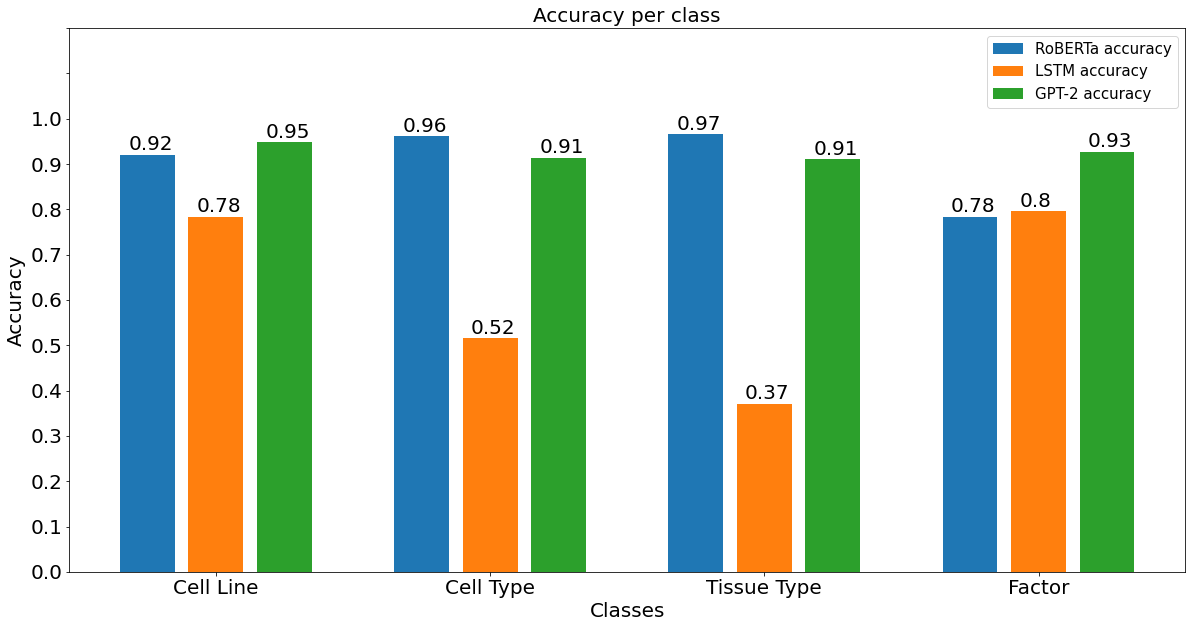

In [106]:
width = 1
x = np.arange(0,len(attribute_names)*(1+width),1+width)
fig = plt.figure(figsize = (20,10))
ax = plt.subplot(111)
x_label = attribute_names
y_1 = lstm_rec
y_2 = gpt2_acc
y_3 = robe_acc
robe_plot = ax.bar(x , y_3, width-0.6, label = "Classification with RoBERTa")
lstm_plot = ax.bar(x + width - 0.5,y_1, width - 0.6, label = "Translation with LSTM + attention")
gpt2_plot = ax.bar(x + width,y_2,width - 0.6, label = "Translation with GPT-2")

ax.set_xlabel('Classes', fontsize = 20)
ax.set_title("Accuracy per class", fontsize = 20)
ax.set_ylim(0,1)
ax.set_xticks(x + width/2)
ax.set_xticklabels(x_label, fontsize = 20)
ax.set_yticks(np.arange(0,1.25,0.1))
ax.set_yticklabels([str(round(x,2)) for x in np.arange(0,1.1,0.1)], fontsize = 20)

ax.legend(fontsize = 15)

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(len(x))]
for i in range(4):
    ax.text(x[i] - 0.14 , y_3[i] + 0.01, str(round(y_3[i],2)), fontsize = 20)
    ax.text(x[i] + width - 0.64, y_1[i]+0.01, str(round(y_1[i],2)), fontsize = 20)
    ax.text(x[i] + width - 0.14, y_2[i]+0.01, str(round(y_2[i],2)), fontsize = 20)

## EVALUATION ON CISTROME WITHOUT NONE VALUES

In [55]:
lstm_predicted_values_no_none = []
lstm_target_values_no_none = []
lstm_errors_no_none = []
for pr,tg in zip(predictions_lstm, targets_lstm):
    list_pred = []
    list_targ = []
    try:
        for i in range(len(attributes) - 1):
            if(attributes[i] in pr):
                list_pred.append(pr.split(attributes[i])[1].split(" - ")[0])
            else:
                list_pred.append("<missing>")
            list_targ.append(tg.split(attributes[i])[1].split(" - ")[0])
        if(attributes[i + 1] in pr):
            list_pred.append(pr.split(attributes[i+1])[1].replace(" <end>", "").replace(" <pad>", ""))
        else:
            list_pred.append("<missing>")
        list_targ.append(tg.split(attributes[i+1])[1].replace(" <end>", ""))
    
        if("none" not in list_targ):
            lstm_predicted_values_no_none.append(list_pred)
            lstm_target_values_no_none.append(list_targ)
    except:
        lstm_errors.append([pr,tg])

In [56]:
gpt2_predicted_values_no_none = []
gpt2_target_values_no_none = []
errors = []
for pr,tg in zip(predictions_gpt2, targets_gpt2):
    list_pred = []
    list_targ = []
    try:
        for i in range(len(attributes) - 1):
            if(attributes[i] in pr):
                list_pred.append(pr.split(attributes[i])[1].split(" - ")[0])
            else:
                list_pred.append("<missing>")
            list_targ.append(tg.split(attributes[i])[1].split(" - ")[0].replace(" $",""))
        if(attributes[i + 1] in pr):
            list_pred.append(pr.split(attributes[i+1])[1].replace(" $", "").replace(" <pad>", ""))
        else:
            list_pred.append("<missing>")
        list_targ.append(tg.split(attributes[i+1])[1].replace(" $", ""))
        if("none" not in list_targ):
            gpt2_predicted_values_no_none.append(list_pred)
            gpt2_target_values_no_none.append(list_targ)
    except:
        errors.append([pr,tg])

In [61]:
## TODO ROBERTA

In [59]:
lstm_pre, lstm_rec, lstm_acc = compute_pr_re_acc(lstm_predicted_values_no_none, lstm_target_values_no_none)
gpt2_pre, gpt2_rec, gpt2_acc = compute_pr_re_acc(gpt2_predicted_values_no_none, gpt2_target_values_no_none)

In [60]:
lstm_pre

[0.7660644504836948, 0.6911522761736, 0.5549308186160439, 0.7868772653344577]